# Part 1

In [1]:
import tifffile
import tensorflow as tf
import numpy as np

In [2]:
file_path = 'microtubule_whole_FOV.tif'
file_path_multiple = 'microtubule.tif'

In [3]:
image_tensor = tifffile.imread(file_path)
image_tensors = tifffile.imread(file_path_multiple)

In [4]:
import matplotlib.pyplot as plt
import math

# Function to display the image
def display_image(image, p=False):

    # Print the image shape
    if p:
        print(f"Image shape: {image.shape}")
        print(image)

    # Ensure the image tensor is in the range [0, 1]
    # image_normalized = image / 255.0

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# display images in a grid
def display_images_grid(image_tensors, cols):
    # Calculate the number of rows needed
    rows = math.ceil(len(image_tensors) / cols)

    # Set the figure size
    plt.figure(figsize=(15, rows * 3))

    # Loop through all the images and plot them in a grid
    for i, image_tensor in enumerate(image_tensors):
        plt.subplot(rows, cols, i + 1)
        # Normalize and display the image
        plt.imshow(image_tensor, cmap='gray')
        plt.title(f"Frame: {i + 1}")
        plt.axis('off')
    plt.show()




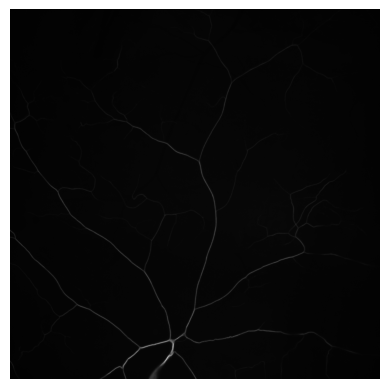

In [5]:
display_image(image_tensor)

In [7]:
print(image_tensor.dtype) # <-- 16-bit image

uint16


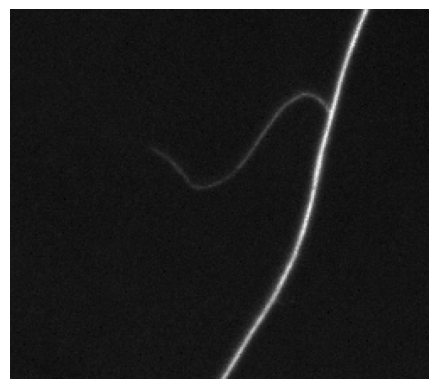

In [233]:
display_image(image_tensors[0])

## Method 1 - Manual Image Preprocessing

In [8]:
THRESHOLD_VALUE = 20             # <----- Note: this threshold value is set based on experiential experienments

In [9]:
import cv2
from scipy.ndimage import gaussian_filter
from skimage import measure


# Function to smooth the images before segmentation
def smooth_images(image_tensors):
    # apply Gaussian filter
    images_smoothed = [cv2.GaussianBlur(image, (5, 5), 0) for image in image_tensors]
    return images_smoothed

# Function to segment microtubules from the preprocessed images
def segment_microtubules(image, threshold_value=THRESHOLD_VALUE):
    # Apply a threshold to segment the microtubules
    # Normalize the image.
    # This step converts a 16-bit image to a 8-bit image    <----- This could lead to loss of information
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresh

def segment_images(images_smoothed):
  segmented_images = [segment_microtubules(image) for image in images_smoothed]
  return segmented_images


In [10]:
images_smoothed = smooth_images(image_tensors)
images_segmented = segment_images(images_smoothed)

Image shape: (219, 248)
[[186 186 186 ... 182 181 182]
 [185 185 186 ... 182 180 181]
 [183 184 187 ... 180 179 179]
 ...
 [192 192 193 ... 192 193 194]
 [197 196 196 ... 191 190 191]
 [199 198 197 ... 191 189 190]]


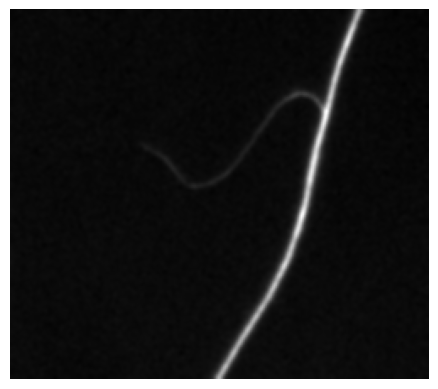

In [11]:
display_image(images_smoothed[38], True)

Image shape: (219, 248)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


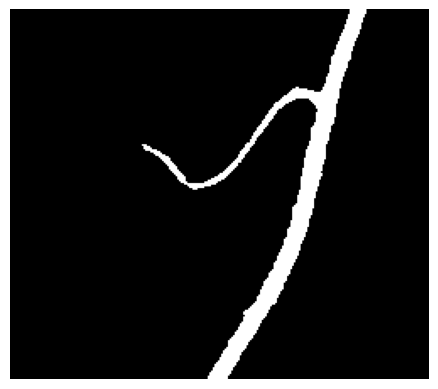

In [12]:
display_image(images_segmented[38], True)

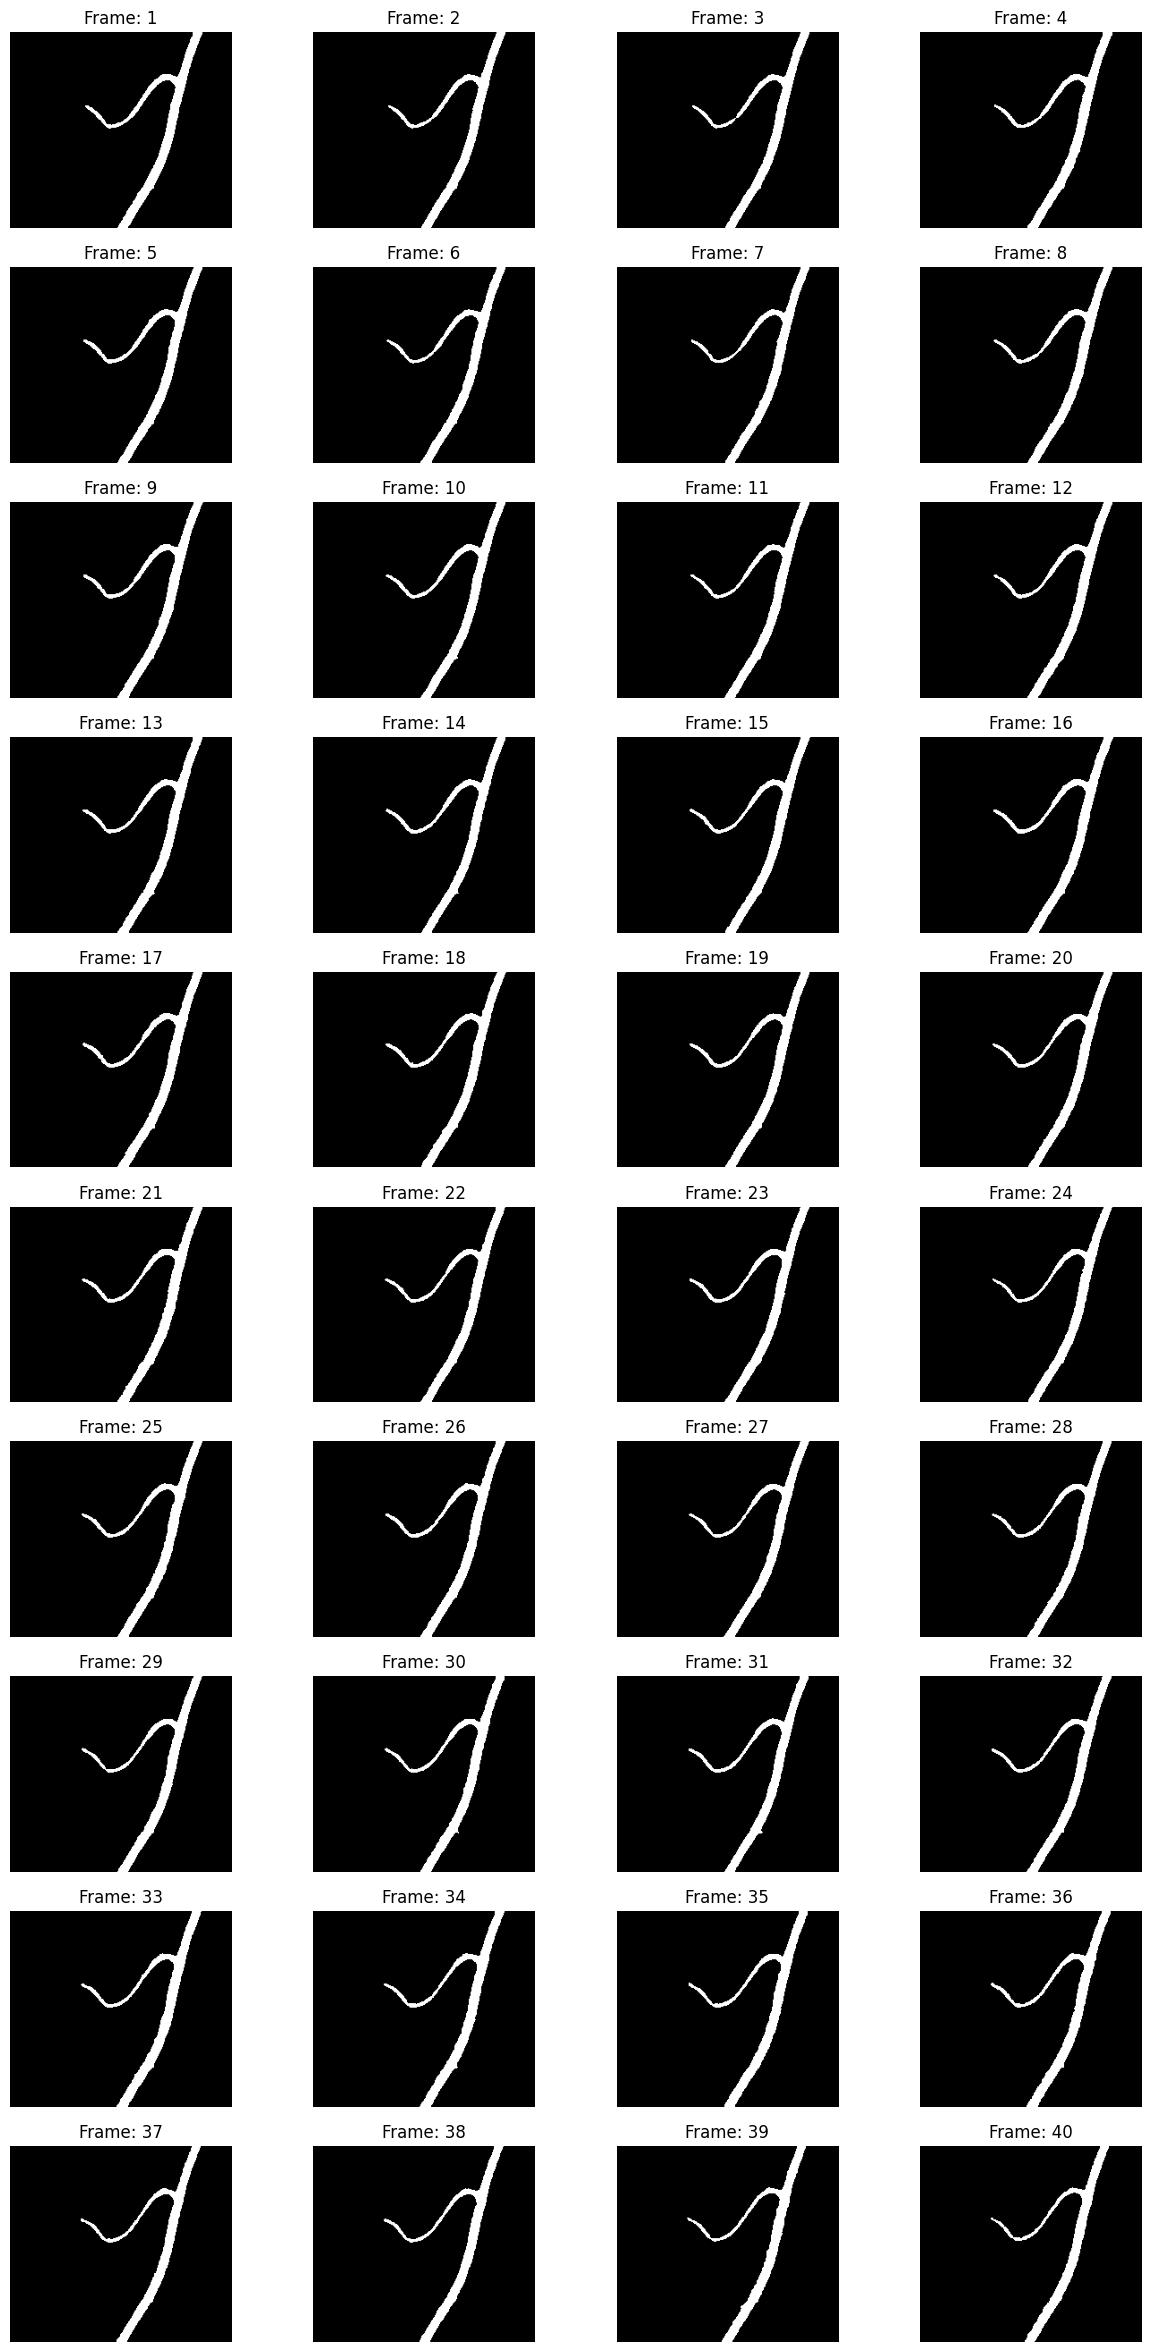

In [13]:
display_images_grid(images_segmented, 4)

In [14]:
# Function to measure the lengths of the microtubules
# The binary image input is expected to have the microtubules as white the background as black.

# Each disconnected microtubule region is given a unique label,
# which also speaks for the importance for setting an ideal threshhold value in previous step.



def measure_lengths(binary_image):
    # Label different microtubul regions
    labels = measure.label(binary_image)
    properties = measure.regionprops(labels)
    lengths = [prop.major_axis_length for prop in properties]
    return lengths

# Measure lengths of microtubules in each segmented image
pixels_per_image = [measure_lengths(image) for image in images_segmented]

# Considering the resolution of 162nm/piexel; unit: nm
lengths_per_image = [[p * 162 for p in l] for l in pixels_per_image]

# Output the lengths for each image
lengths_per_image


[[39869.28510700268],
 [39762.309040413864],
 [39925.754666985944],
 [39846.37987439909],
 [39536.18843902706],
 [39993.994671292945],
 [39828.631397662924],
 [39864.59365774744],
 [39681.5797620288],
 [39648.981756008034],
 [40012.20355656302],
 [39994.473146593504],
 [39966.73382802063],
 [39565.97151902258],
 [39890.979693623805],
 [39724.519709266664],
 [39797.87132152432],
 [39896.01611168391],
 [39814.054923912634],
 [39868.114221617565],
 [39872.64297563264],
 [39883.908302551616],
 [39757.66726845372],
 [40123.42042609146],
 [39786.405022788036],
 [39928.42695507637],
 [40123.29811383941],
 [39997.45960872233],
 [40104.77607209519],
 [40060.14982523342],
 [39688.57573289089],
 [40094.21042004611],
 [40095.04108557339],
 [40120.29438820915],
 [40084.12907454767],
 [40152.27758852994],
 [40119.892619406826],
 [40171.286645897264],
 [40238.595845752614],
 [40490.653117791335]]

#### To account for this variability and determine significant changes in microtubule length, it's important to establish an error range or confidence interval within which variations in length are considered to be due to measurement error or natural fluctuations rather than true biological changes. (Maybe perform a statistical analysis of microtubule lengths across a control set of images to determine the natural variability in measurements. )

#### Define a threshold for significant change in length that is outside the error range. Only changes in length that exceed this threshold would be considered actual growth or retraction of microtubules.

In [15]:
# Let's give it a "random" error range here before we conduct any formal statsitic analysis
# I utilized 1% of average microtubule length, which is 50 micrometers based on research result

ERROR_RANGE = 500 # unit: nm.

# We drop all frames where there is missing part in microtubule
lengths = [l for l in lengths_per_image if len(l) == 1]

# Then we can determine if there is dynamical microtubule based on assumed threshold values
FOUND = False
lower_bound = lengths[0][0] - ERROR_RANGE
upper_bound = lengths[0][0] + ERROR_RANGE
for l in lengths:
  if l[0] < lower_bound or l[0] > upper_bound:
    FOUND = True
    break

print("Dynamical Microtubule Detected!") if FOUND else print("No Dynamical Microtubule Detected!")


Dynamical Microtubule Detected!


In [16]:
# One function (Put everything above into one function)

ERROR_RANGE = 500 # unit: nm.
PIXEL_LENGTH = 162 # unit: nm


def detect_dynamical_microtubule(time_series_images, error_range=ERROR_RANGE, pixel_length=PIXEL_LENGTH):
  images_smoothed = smooth_images(time_series_images)
  images_segmented = segment_images(images_smoothed)

  # Measure lengths of microtubules in each segmented image
  pixels_per_image = [measure_lengths(image) for image in images_segmented]

  lengths_per_image = [[p * PIXEL_LENGTH for p in l] for l in pixels_per_image]

  # Replace all frames where there is missing part in microtubule with the initial length in the list as a placeholder
  # Consider time sequence length should be constant for later RNN model
  lengths = [l[0] if len(l) == 1 else lengths_per_image[0][0] for l in lengths_per_image]

  FOUND = False
  lower_bound = lengths[0] - ERROR_RANGE
  upper_bound = lengths[0] + ERROR_RANGE
  for l in lengths:
    if l < lower_bound or l > upper_bound:
      FOUND = True
      break

  print("Dynamical Microtubule Detected!") if FOUND else print("No Dynamical Microtubule Detected!")

  return lengths


In [17]:
lengths = detect_dynamical_microtubule(image_tensors)

Dynamical Microtubule Detected!


**Assumptions and Notes**

*  The function assumes that dynamical microtubules can be identified solely based on length variations within a specified error range.
* It only considers microtubules detected as single entities in each image, potentially ignoring cases where multiple microtubules are present. In our case, we calculate the total length of the main and side branches. However, it can be adjusted due to different requirements without too much burden.
* The accuracy of detection heavily relies on the effectiveness of the image smoothing and segmentation processes.


## Method 2 - Super-resolution Generative *Moldel*

* To solve/undermine the variability issue that could be caused due to non-biological changes, such as low image quality (e.g., noise, low contrast), a latent diffusion model (known for its superresolution charactertistic) or any other suitable generative model could potentially enhance the images, making structures like microtubules more distinct and easier to segment accurately.

* In cases when parts of the microtubules are not visible due to imaging issues, as you can see from previous visilizations of images, a generative model like LDM might be able to fill in the missing information based on the learned distribution of microtubule appearances in our datasets.

* Even though the LDM is open sourced, they were not trained on datasets relevant to our use cases initially. To achieve the best performance, this requires learning mappings from low-resolution to high-resolution images based on training datasets that contain pairs of low and high-resolution images, which however could be very resource-consuming if no existing datasets could be used.

### However, it's still crucial to validate that any improvements in measurement consistency are not at the expense of biological accuracy.

## Method 3 - Segment Anything Model

* To enhance image visibility, we could also condiering using an open-sourced vision foundation model released by META for segmentation tasks. It has strong zero-short generalization capabilities, which is perfect for our use case.

In [165]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fe0_wl_e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fe0_wl_e
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=466c7a156a1ee5fee40a092221297a5248937ef65ddc12f5a7232c5249ee87ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-15c3he7e/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


### Some experienments have been done and results were dispalyed in Problem2 solution notebook, which shows villia SAM without any finetuning having poor performance in our use case.

# PART 2

**Assumptions and Notes**

* Given we are working with a Field of View (FOV) movie, we have to consider how to extract the individual branches from each frame for analysis. We can utiliz a model to predict bounding boxes around each branch to get data for branches over time. This step is crucial because it allows us to isolate each branch as a separate entity for further analysis with the detect_dynamical_microtubule function and the RNN. We can either use a pre-trained model like YOLO or train one by ourselves using our own private datasets. It should not be too hard given my previous experience training a model to detect human eye attention by first cropping the eye part out of a human face. (https://github.com/babelpainterwell/Attention_Detector)
* Instead of using a CNN, which has an emphasis on image patterns, we care more about the changes of lengths over time. To better handle time series data , I will utlize a RNN model architecture. The input to the RNN in this context would be a sequence of numerical values representing the lengths of a single microtubule branch measured at different time stamps, which we can get by calling the 'detect_dynamical_microtubule' function provided in Part 1.



In [ ]:
# PESEUDO CODE -- NOT REAL CODE
# PESEUDO CODE -- NOT REAL CODE
# PESEUDO CODE -- NOT REAL CODE

DetectionModel = 'YOLOv5'

def detect_branches_in_frame(frame):
    detected_branches = DetectionModel.predict(frame)
    # Returns bounding boxes for each detected branch in one frame
    # which should only contain the four corners of the bounding box
    return detected_branches


def extract_branch_from_bbox(frame, bbox):
    # Extracts the branch image from the frame using the bounding box coordinates
    # return one image
    x, y, w, h = bbox
    branch_image = frame[y:y+h, x:x+w]
    return branch_image

# Track each individual branch across different frames!!!
# We ASSUME that the branches are detected in the same order in every frame. <-- which might not be true in real time!!!!

def extract_branches_from_fov(fov_movie, num_branches):
    # Initialize branches_data with a list for each branch
    branches_data = [[] for _ in range(num_branches)]

    for frame in fov_movie:
        detected_branches = detect_branches_in_frame(frame)

        for i, bbox in enumerate(detected_branches):
            branch_image = extract_branch_from_bbox(frame, bbox)
            branches_data[i].append(branch_image)

    return branches_data


# Extract branches assuming they are detected in the same order in every frame
branches_data = extract_branches_from_fov(fov_movie, num_branches)

def preprocess_image(image):
    # Implement preprocessing steps like normalization, resizing..
    # Make sure constant input for RNN

    pass

def preprocess_branch_images(branches_data):
    for branch_sequence in branches_data:
        for i in range(len(branch_sequence)): # each time frame of a branch
            branch_sequence[i] = preprocess_image(branch_sequence[i])
    return branches_data

def get_features_from_branches(branches_data):
    features = []
    for branch_sequence in branches_data: # each branch - a list of images
        branch_features = detect_dynamical_microtubule(branch_sequence)
        features.append(branch_features)
    return features


# Architecture for example, could be adjusted based on demands
def build_rnn_model(input_shape, output_units=1):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(NUM_FRAMES, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(NUM_FRAMES),
        tf.keras.layers.Dense(output_units, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_rnn_model(model, train_data):
    model.fit(train_data[0], train_data[1], epochs=10)

# DEFINE A evaluate function
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy}")

In [222]:
# Overall Flow
num_branches = 1000
# Load FOV movie
fov_movie = load_fov_movie("fov_movie")
# Load the labels
labels = load_labels("labels")
NUM_FRAMES = "WHATEVER"
EPOCHS = 'WHATEVER'
BATCH_SIZE = 'WHATEVER'


# Step 1: Load and preprocess the FOV movie
branches_data = extract_branches_from_fov(fov_movie, num_branches)
branches_data = preprocess_branch_images(branches_data)

# Step 2: Extract features and prepare data for RNN
features = get_features_from_branches(branches_data)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Build the model
input_shape = X_train.shape[1:] # no batch size dimension
rnn_model = build_rnn_model(input_shape)

# Train the model
train_rnn_model(rnn_model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Evaluate the model
evaluate_model(rnn_model, X_test, y_test)


### Final comment

We could also choose to use some fancier models such as transformers for dealing with sequential data. However, they come with trade-offs: they often require substantial data for training and can be computationally demanding, making them less suitable for smaller datasets or resource-constrained environments.